In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
#from mlxtend.frequent_patterns import apriori
from apyori import apriori 
from itertools import combinations, groupby
from collections import Counter
from Server_Assign_apriori import server_association_apriori
from format_rules_apriori import  format_rules_apriori
from assign_test_apriori2 import assign_servers_output
from apriori_rules import association_rules

In [2]:
#load data
# based off https://www.datatheque.com/posts/association-analysis/

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [4]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [5]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [9]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

In [10]:
df['norm_latency']=df['Duration']/df['Packets']

In [11]:
df_train=df[df['Date']<'2017-08-08'] #first 6 days
df_test=df[df['Date']>'2017-08-08'] #last day

In [12]:
percentile=0.9
confidence=1
apps_server=20

In [13]:
data=df[['Date', 'Src_IP', 'Dst_IP']]
#melt 
data2=data
data2=pd.melt(data2, id_vars=['Date'])

In [14]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
# Convert from DataFrame to a Series, with order_id as index and item_id as value
#necessary for assocation mining
data2=data2[['Date', 'value']]
data2.columns=['Date', 'IP']
data_series = data2.set_index('Date')['IP'].rename('IP')

In [15]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [16]:
per_90=np.percentile(pairs_count['frequency'], [90])

min_support=per_90/len(df)
min_support=min_support[0]

In [17]:
min_support

3.24945345658779e-05

In [15]:
rules = association_rules(data_series, min_support)  

Starting order_item:               16371984
Items with support >= 3.24945345658779e-05:            9041
Remaining order_item:              16371372
Remaining orders with 2+ items:     6709534
Remaining order_item:              16370809


/home/ubuntu/notebook/Manifold/iter_apriori.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           92273
Item pairs with support >= 3.24945345658779e-05:      17282



In [20]:
len(rules)

17282

In [35]:
rules.head()

,IP_A,IP_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift,pairs,pairs2
6075,14218_62,14218_62,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[14218_62, 14218_62]","(14218_62, 14218_62)"
11531,192.168.200.120,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.120, 192.168.200.99]","(192.168.200.120, 192.168.200.99)"
11530,192.168.200.73,192.168.200.99,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.73, 192.168.200.99]","(192.168.200.73, 192.168.200.99)"
11529,192.168.200.188,192.168.200.189,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[192.168.200.188, 192.168.200.189]","(192.168.200.188, 192.168.200.189)"
3049,12914_60,12914_60,3,0.000045,8,0.000119,8,0.000119,0.375,0.375,3145.094063,"[12914_60, 12914_60]","(12914_60, 12914_60)"


In [28]:
formated_rules=format_rules_apriori(rules, orig_df=df,apps_server=20)

In [72]:
formated_rules['IP_B'].nunique()

143

In [73]:
formated_rules['IP_A'].nunique()

140

In [75]:
(server_assignments)

,IP,serverid
10001_213,10001_213,5.0
10003_226,10003_226,6.0
10008_10,10008_10,7.0
10008_16,10008_16,8.0
10008_24,10008_24,0.0
10008_33,10008_33,0.0
10008_9,10008_9,0.0
10012_14,10012_14,4.0
10013_238,10013_238,1.0
10016_175,10016_175,4.0


In [29]:
server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model = server_association_apriori(formated_rules, df, apps_server) #this function loaded fr

In [18]:
from iter_apriori import freq
from iter_apriori import order_count
from iter_apriori import get_item_pairs
from iter_apriori import merge_item_stats
from iter_apriori import merge_item_name
from itertools import combinations, groupby
from collections import Counter

order_item=data_series
item_stats             = freq(data_series).to_frame("freq")
item_stats['support']  = item_stats['freq'] / order_count(data_series) * 100

In [28]:
item_stats.head()

,freq,support
192.168.220.51,1794154,26.738123
192.168.220.47,1098518,16.371120
DNS,995938,14.842379
192.168.210.55,503965,7.510547
192.168.220.45,498502,7.429133


In [19]:
 # Filter from order_item items below min support 
qualifying_items       = item_stats[item_stats['support'] >= min_support].index
order_item             = order_item[order_item.isin(qualifying_items)]

In [23]:
order_size             = freq(order_item.index)
qualifying_orders      = order_size[order_size >= 2].index
order_item2             = order_item[order_item.index.isin(qualifying_orders)]


In [25]:
len(order_item2)

16370809

In [26]:
# Recalculate item frequency and support
item_stats2             = freq(order_item2).to_frame("freq")
item_stats2['support']  = item_stats2['freq'] / order_count(order_item2) * 100


In [29]:
item_stats2.head()

,freq,support
192.168.220.51,1794120,26.739860
192.168.220.47,1098502,16.372255
DNS,995938,14.843624
192.168.210.55,503956,7.511043
192.168.220.45,498499,7.429711


In [22]:
len(data_series)

16371984

In [21]:
len(order_item)

16371372

In [47]:
order_size             = freq(order_item.index)

In [56]:
len(order_size[order_size>=2])

6710097

In [30]:
total_latency

2014119.5810000007

In [31]:
total_latency_model

1144726.8879999986

In [33]:
server_df

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,hour,Src_Server,Dst_Server,duration_pred
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.001500,0,0.0,0.0,0.000
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.000000,0,0.0,0.0,0.000
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.002000,0,0.0,0.0,0.000
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.000000,0,NaN,3.0,0.000
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.000000,0,0.0,0.0,0.000
5,2017-08-02 00:00:02.847,0.210,192.168.210.54,59628,10000_34,443.0,2,154,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.105000,0,3.0,NaN,0.210
6,2017-08-02 00:00:03.568,0.000,192.168.100.11,445,192.168.220.42,58001.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.42]","(192.168.100.11, 192.168.220.42)",0.000000,0,0.0,0.0,0.000
7,2017-08-02 00:00:03.567,0.002,192.168.220.42,58001,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.42]","(192.168.100.11, 192.168.220.42)",0.001000,0,0.0,0.0,0.000
8,2017-08-02 00:00:04.193,0.000,192.168.100.11,445,192.168.220.46,49770.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.46]","(192.168.100.11, 192.168.220.46)",0.000000,0,0.0,1.0,0.000
9,2017-08-02 00:00:04.192,0.001,192.168.220.46,49770,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.46]","(192.168.100.11, 192.168.220.46)",0.000500,0,1.0,0.0,0.001


### Why do we need association rules at all? we already have a frequent list count of all the pairs, What if we just filter this list and then assign the servers to the pairs that pass the min threshold.

In [22]:
min_support_whole=min_support*len(df)
pairs_min=pairs_count[pairs_count['frequency']>min_support_whole]

len(pairs_min)
#we get more pairs that pass this min threshold than when we apply the Apriori algorithm

4475

In [39]:
min_support_whole

266.0

In [ ]:
order_item=df_series
item_stats             = freq(order_item).to_frame("freq")
item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

In [61]:
    # Filter from order_item items below min support 
qualifying_items       = item_stats[item_stats['support'] >= min_support].index #only one entry per item b/c getting freq of that item
order_item             = order_item[order_item.isin(qualifying_items)] #the series of each transaction can have repeated IPs

In [62]:
len(qualifying_items ) #individual IPs that pass

9041

In [57]:
order_size             = freq(order_item.index)
qualifying_orders      = order_size[order_size >= 2].index
order_item             = order_item[order_item.index.isin(qualifying_orders)]

In [65]:
# Recalculate item frequency and support
item_stats             = freq(order_item).to_frame("freq")
item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
item_pair_gen          = get_item_pairs(order_item)


item_pairs              = freq(item_pair_gen).to_frame("freqAB")
item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100


/home/ubuntu/notebook/Manifold/iter_apriori.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


In [69]:
item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

In [70]:
item_pairs

freqAB  supportAB
DNS            DNS              14057   0.209490
192.168.210.54 192.168.210.54   16390   0.244259
192.168.210.50 192.168.210.46      98   0.001460
192.168.220.49 192.168.220.51     188   0.002802
               192.168.220.44     147   0.002191
192.168.220.51 192.168.220.44      77   0.001148
192.168.210.56 192.168.210.49     147   0.002191
192.168.210.45 192.168.210.26      71   0.001058
               192.168.210.55     172   0.002563
192.168.210.26 192.168.210.55      35   0.000522
192.168.220.46 192.168.100.11     307   0.004575
192.168.100.11 192.168.210.46     121   0.001803
192.168.220.46 192.168.220.42      91   0.001356
192.168.220.49 192.168.220.48      46   0.000686
192.168.100.11 192.168.220.47     123   0.001833
192.168.210.47 192.168.210.50     128   0.001908
192.168.210.57 192.168.210.57    9953   0.148329
192.168.220.51 192.168.220.51   92912   1.384660
               192.168.220.49     195   0.002906
192.168.220.44 192.168.220.49     150   0.002235
192.168.100.11 192.168.220.43     284   0.004232
               192.168.220.50     155   0.002310
192.168.210.49 192.168.210.56     149   0.002221
192.168.220.47 192.168.220.50      80   0.001192
192.168.100.11 192.168.220.46     306   0.004560
               192.168.220.42     244   0.003636
               192.168.220.49     154   0.002295
192.168.210.2  192.168.210.54       9   0.000134
192.168.210.56 192.168.210.50      83   0.001237
               192.168.210.47     141   0.002101
...                               ...        ...
14359_131      10085_210            1   0.000015
192.168.220.47 10055_110            1   0.000015
10101_41       10009_2              2   0.000030
10063_155      10002_2              1   0.000015
10759_254      10101_41             1   0.000015
               10027_238            2   0.000030
               10009_2              1   0.000015
               10027_234            1   0.000015
               10027_226            1   0.000015
               10662_41             1   0.000015
10101_41       10027_234            1   0.000015
               10662_41             1   0.000015
10027_238      10662_41             1   0.000015
10009_2        10662_41             1   0.000015
10027_234      10662_41             1   0.000015
10027_226      10662_41             1   0.000015
10662_41       10027_238            1   0.000015
10099_178      10085_210            2   0.000030
10275_4        10350_35             1   0.000015
10027_238      10121_229            1   0.000015
10014_233      13801_14             1   0.000015
13047_59       13053_118            2   0.000030
               13053_106            1   0.000015
13053_118      13053_118            1   0.000015
               13053_106            2   0.000030
192.168.210.56 10690_254            1   0.000015
10021_204      10017_62             1   0.000015
               10018_32             1   0.000015
10246_120      10042_70             3   0.000045
192.168.100.11 10692_129            1   0.000015

[92273 rows x 2 columns]

In [59]:
len(order_item)#multiple IPs can pass this

16371984

## Same thing with train/test data

In [18]:
server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model =assign_servers_output(df_train=df_train, df_test=df_test, percentile=percentile, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/assign_test_apriori2.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/assign_test_apriori2.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


Starting order_item:               12710576
Items with support >= 3.807852610298699e-05:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106
Remaining order_item:              12710576


/home/ubuntu/notebook/Manifold/iter_apriori.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           75258
Item pairs with support >= 3.807852610298699e-05:      24490



In [23]:
server_df['hour']=None
server_df['hour']=pd.DatetimeIndex(server_df['Date']).hour

In [24]:
#sum up by an hourly timestep, get the average transaction time (s)

server_df_hour=server_df.groupby('hour')[['Duration', 'duration_pred']].mean().reset_index()

In [25]:
server_df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,Src_Server,Dst_Server,duration_pred,hour
0,2017-08-08 00:00:00.760,0.144,10692_129,443,192.168.210.54,52204.0,3,936,2017-08-08,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0480,NaN,4.0,0.144,0
1,2017-08-08 00:00:00.746,0.158,192.168.210.54,52204,10692_129,443.0,2,334,2017-08-08,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0790,4.0,NaN,0.158,0
2,2017-08-08 00:00:02.205,0.000,11948_124,80,192.168.220.51,40971.0,1,279,2017-08-08,"[11948_124, 192.168.220.51]","(11948_124, 192.168.220.51)",0.0000,NaN,0.0,0.000,0
3,2017-08-08 00:00:02.126,0.023,DNS,53,192.168.220.51,54811.0,2,371,2017-08-08,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0115,0.0,0.0,0.000,0
4,2017-08-08 00:00:02.098,0.031,192.168.220.51,54811,DNS,53.0,2,156,2017-08-08,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0155,0.0,0.0,0.000,0


In [26]:
#how many rules did we create?
len(server_assignments)

226

This means the next day we assigned 226 rules that were in effect the whole 24 hours

This is what percentage of IPs assigned:

In [27]:
unique_IPs=server_df['Src_IP'].nunique()+server_df['Dst_IP'].nunique()
len(server_assignments)/unique_IPs

0.023091856544395627

In [28]:
#What was the latency reduction? %
( total_latency- total_latency_model)/  total_latency

0.2642127380851742

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


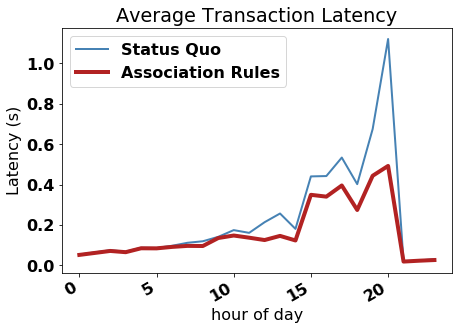

In [29]:
#plot average transaction time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib as matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(server_df_hour['hour'], server_df_hour['Duration'], color='steelblue', linewidth=2.0, label='Status Quo')
ax.plot(server_df_hour['hour'], server_df_hour['duration_pred'], color='firebrick', linewidth=4.0, label='Association Rules')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
plt.legend(loc='upper left')
fig.savefig('Average_transaction_latency_Apriori.png')

## How much money did we save in this example test day?

the reason why I provided you with bandwidth pricing is the following:
If applications are co-located you pay nothing
so you can caulcute the price by using the bytes transmitted and recieved (as per the dataset)
and just put 0 for any machine that is co-located

Bandwidth is charged on a pay-as-you-go basis, and it is calculated on the actual bandwidth usage (GB) in your last month multiplied by AWS bandwidth charges ($0.12 / GB). For example, if your server consumed 100GB bandwidth in the month, you will be charged for $12 (100GB x $0.12).https://support.cloudways.com/aws-bandwidth-charges/

BAndwith measured in bytes/second. so if we sum up the bytes over a period of time, we can know the min bandwith we would need to order and pay for.

Assume $0.12/GB of data transferred.
If latency = 0, then we will set Bytes=0 b/c we did not have to really transfer them and no need to allocate extra bandwith..
To calculate original cost = Sum up the Bytes, multiply by this $rate

To calculate the model cost, we will set any byte where servers match =0, then sum up bytes and multipy by $rate.


In [52]:
cost_rate=0.12
server_df['Bytes_model']=server_df['Bytes']
server_df.loc[server_df['Src_Server']==server_df['Dst_Server'], 'Bytes_model']=0
orig_GB=(server_df['Bytes'].sum()/10E9)#convert from byte to GB, this is over the test period in 'hours' below
model_GB=(server_df['Bytes_model'].sum()/10E9)
time=(server_df['Date'].iloc[-1]-server_df['Date'][0]).total_seconds() #total time in seconds
hours=time//3600 #total time in hours

In [68]:
orig_GB

4.7446498244

In [69]:
(orig_GB)/hours #Mb/s

0.20628912279999997

In [66]:
(model_GB*10E3)/time

0.30632015713864647

In [70]:
orig_bandrate=orig_GB/time
model_bandrate=model_GB/time

orig_cost=((orig_GB)/hours) *24*365*cost_rate # $/yr
model_cost=((model_GB)/hours) *24*365*cost_rate

In [71]:
orig_cost

216.85112588735996

In [72]:
model_cost

120.95624932910609

In [73]:
(orig_cost-model_cost)/orig_cost

0.4422152578910981

### How does this model compare to random assignment?



In [ ]:
#Need to assign random servers to the IP addressed, however b/c we did not assign a server to all the IP addresses in our model run, we will only assign servers to the same proportion of the data.

#How many servers did we assign in the Src_server column?
num_src_assign=server_df['Src_Server'].count()
num_dst_assign=server_df['Dst_Server'].count()


In [41]:
xx_src=np.random.choice(len(df_test), num_src_assign) #which rows are randomly assigned src servers
xx_dst=np.random.choice(len(df_test), num_dst_assign) #which rows are randomly assigned dst servers
num_servers=server_assignments['serverid'].nunique()
server_df['rnd_src_server']=None
server_df['rnd_dst_server']=None

In [42]:
rnd_src_servers=[]
for x in range(len(xx_src)):
  rnd_src_servers.append(random.randint(0,num_servers))

rnd_dst_servers=[]
for x in range(len(xx_dst)):
  rnd_dst_servers.append(random.randint(0,num_servers)) #create random numbers for dst serve

In [43]:
server_df['rnd_src_server'][xx_src]=rnd_src_servers
server_df['rnd_dst_server'][xx_dst]=rnd_dst_servers

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
len(server_df[server_df.rnd_src_server==server_df.rnd_dst_server])/len(server_df) #we get 1% matches

0.0162620500091768

In [48]:
server_df['duration_rnd']=server_df['Duration']
server_df['duration_rnd'][server_df['rnd_src_server']==server_df['rnd_dst_server']]=0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [53]:
random_reduction=(server_df['Duration'].sum()-server_df['duration_rnd'].sum())/ server_df['Duration'].sum() #new updated latency with the random assignment

In [54]:
model_reduction=(server_df['Duration'].sum()-server_df['duration_pred'].sum())/ server_df['Duration'].sum() 

In [55]:
latency_matrix=pd.DataFrame([random_reduction, model_reduction], ['Random Assignment', 'Association Rules'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


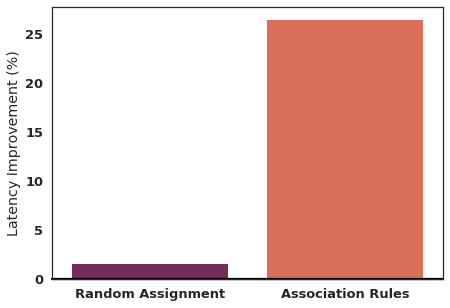

In [56]:
import seaborn as sns
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)
matplotlib.rc('font', **font)
# Set up the matplotlib figure
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=latency_matrix.index, y=latency_matrix[0]*100, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Latency Improvement (%)")
fig.savefig('Latency_Improvement_apriori_model_test_bar.png')

Average transaction latency reduction:

In [57]:
avg_latency-avg_latency_model

0.07306354222197572

In [58]:
(avg_latency-avg_latency_model)/avg_latency

0.2642127380851149